In [1]:
from pathlib import Path
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

# Create Data
MultivariateNormal是用于定义多变量正态分布的类。它可以用来生成服从多变量正态分布的随机样本或计算概率密度函数


torch.diag函数的作用是从给定的一维张量（或列表）创建一个对角矩阵。对角矩阵是一个主对角线上元素非零，其余元素为零的方阵。

In [3]:
import torch
from torch.distributions import MultivariateNormal

# 定义均值向量和协方差矩阵
mean = torch.tensor([0.0, 0.0])
covariance_matrix = torch.tensor([[1.0, 0.5], [0.5, 2.0]])

# 创建MultivariateNormal对象
mvn = MultivariateNormal(mean, covariance_matrix)

# 生成随机样本
samples = mvn.sample()
print("Generated samples:", samples)

# 计算概率密度函数（PDF）
x = torch.tensor([0.5, 0.5])
pdf = mvn.log_prob(x)
print("PDF at x:", pdf)

Generated samples: tensor([0.337, 0.339])
PDF at x: tensor(-2.261)


In [4]:
torch.diag(tensor([5.,5.]))

tensor([[5., 0.],
        [0., 5.]])

In [5]:
n_clusters=6
n_samples=250

In [6]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551],
        [ 25.858,   4.740],
        [ 16.877,  -4.942]])

In [7]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [8]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices) # torch.cat是PyTorch中的一个张量拼接函数，用于在给定维度上将多个张量连接起来。
data.shape

torch.Size([1500, 2])

In [9]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

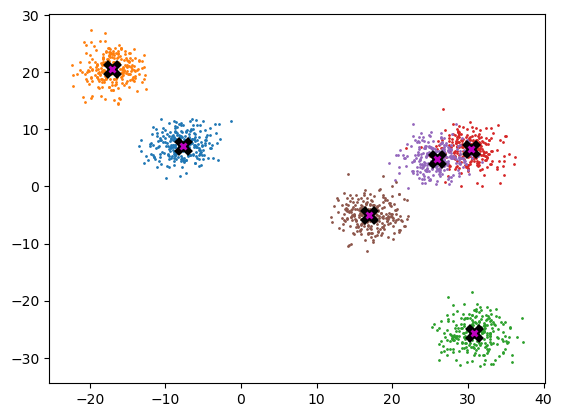

In [10]:
plot_data(centroids, data, n_samples)

# Mean Shift

In [11]:
midp = data.mean(0)
midp

tensor([13.182,  1.400])

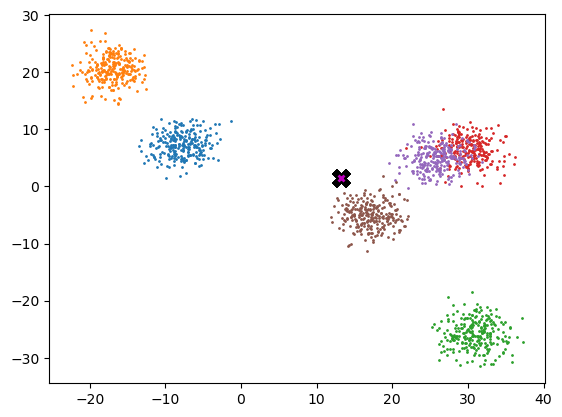

In [12]:
plot_data([midp]*6, data, n_samples)

In [13]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [14]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

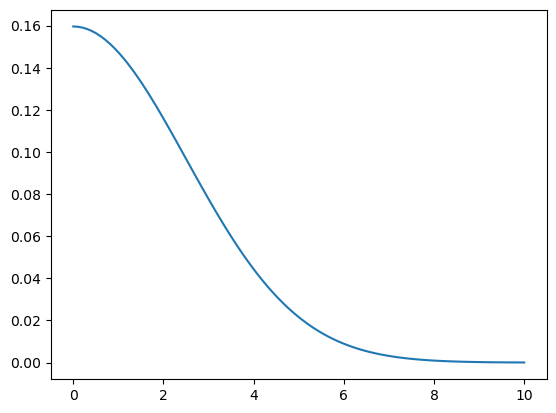

In [15]:
plot_func(partial(gaussian, bw=2.5))

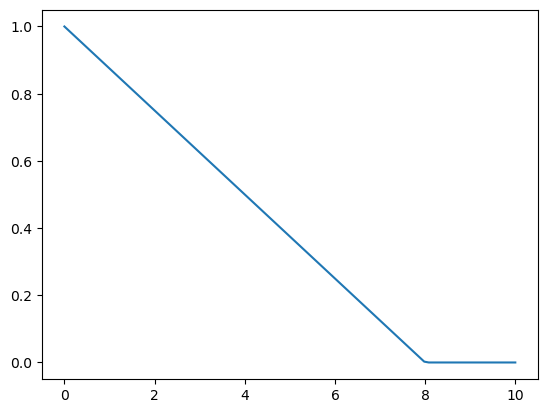

In [16]:
def tri(d, i): return (-d+i).clamp_min(0)/i
plot_func(partial(tri, i=8))

In [17]:
X = data.clone()
x = data[0]
x

tensor([-3.996,  6.706])

In [18]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [19]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 4.785, -1.340],
        [ 5.368, -2.768],
        [ 1.882, -4.115],
        [ 0.812, -3.256],
        [ 2.307, -3.341],
        [ 4.190, -0.450],
        [ 4.235, -2.280]])

In [20]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 4.785, -1.340],
        [ 5.368, -2.768],
        [ 1.882, -4.115],
        [ 0.812, -3.256],
        [ 2.307, -3.341],
        [ 4.190, -0.450],
        [ 4.235, -2.280]])

In [21]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 4.969, 6.039, 4.525, 3.356, 4.061, 4.214, 4.809])

In [22]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.022,     0.009,  ...,     0.000,     0.000,     0.000])

In [23]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [24]:
weight[:,None].shape

torch.Size([1500, 1])

In [25]:
weight[:, None]*X

tensor([[    -0.638,      1.070],
        [    -0.194,      0.178],
        [    -0.081,      0.082],
        ...,
        [     0.000,     -0.000],
        [     0.000,     -0.000],
        [     0.000,     -0.000]])

In [26]:
px = (weight[:, None]*X).sum(0)/weight.sum() # 计算x的值
px

tensor([-6.156,  7.084])

In [27]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [28]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [29]:
%time X=meanshift(data)

CPU times: user 1.51 s, sys: 3.77 ms, total: 1.51 s
Wall time: 1.51 s


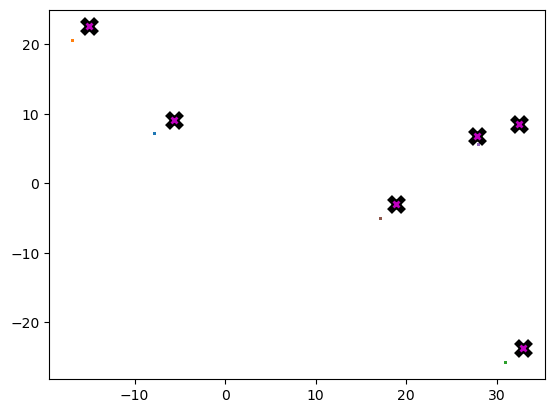

In [30]:
plot_data(centroids+2, X, n_samples)

# Animation

In [31]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [32]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [33]:
X = data.clone()
fig, ax=plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

# GPU batched algorithm

In [34]:
bs = 5
X = data.clone()
x = X[:bs]
x.shape, X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [35]:
x[:,None].shape, X[None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([5, 1, 2]), torch.Size([1, 1500, 2]), torch.Size([5, 1500, 2]))

In [36]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [37]:
dist_b(X, x)

tensor([[ 0.000,  4.969,  6.039,  ..., 25.169, 24.267, 24.395],
        [ 4.969,  0.000,  1.543,  ..., 29.993, 29.220, 29.242],
        [ 6.039,  1.543,  0.000,  ..., 31.200, 30.273, 30.431],
        [ 4.525,  4.016,  3.737,  ..., 29.007, 27.659, 28.186],
        [ 3.356,  4.410,  4.581,  ..., 27.637, 26.317, 26.818]])

In [38]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [39]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.009,     0.002,  ...,     0.000,     0.000,     0.000],
        [    0.009,     0.199,     0.148,  ...,     0.000,     0.000,     0.000],
        [    0.002,     0.148,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.015,     0.027,     0.035,  ...,     0.000,     0.000,     0.000],
        [    0.049,     0.018,     0.014,  ...,     0.000,     0.000,     0.000]])

In [40]:
weight.shape, X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [41]:
weight[..., None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [42]:
num = (weight[..., None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [43]:
num

tensor([[ -57.838,   70.302],
        [-174.640,  161.473],
        [-131.189,  128.495],
        [ -61.734,   84.824],
        [ -56.978,   81.872]])

In [44]:
torch.einsum('ij,jk->ik', weight,X)

tensor([[ -57.838,   70.303],
        [-174.640,  161.473],
        [-131.189,  128.495],
        [ -61.734,   84.824],
        [ -56.978,   81.872]])

In [45]:
weight@X

tensor([[ -57.838,   70.303],
        [-174.640,  161.473],
        [-131.189,  128.495],
        [ -61.734,   84.824],
        [ -56.978,   81.872]])

In [46]:
div = weight.sum(1, keepdim = True)
div

tensor([[10.060],
        [20.942],
        [15.172],
        [ 9.199],
        [ 9.334]])

In [47]:
num/div

tensor([[-5.749,  6.988],
        [-8.339,  7.711],
        [-8.647,  8.469],
        [-6.711,  9.221],
        [-6.104,  8.772]])

In [51]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i, min(i+bs, n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

In [52]:
data = data.cuda()

In [53]:
X = meanshift(data).cpu()

In [54]:
%timeit -n 5 _=meanshift(data,1250).cpu()

4.03 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


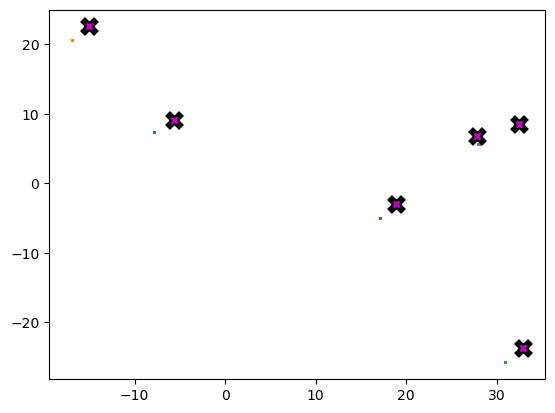

In [55]:
plot_data(centroids+2, X, n_samples)